In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [2]:
from parseprovider import parseprovider
from master import masterproblem
from gen_Q import gen_Q

# 0. Generate Q

In [3]:
input_file = 'data/edisp_3.txt';
N,D,cost,xmin,xmax = parseprovider(input_file)

In [4]:
Q = gen_Q(xmax)
Q

array([[ 0., 10., 10.],
       [10.,  0., 20.],
       [10., 20.,  0.]])

In [5]:
# # Example
# Q = np.array(
#     [
#         [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
#         [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
#         [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
#         [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
#         [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
#     ]
# )

# 1. Introduction

In [6]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('000', 0.0), ('001', 0.0), ('010', 0.0)]


In [7]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(Chadoq2.interaction_coeff / pdist(new_coords) ** 6)
    return np.linalg.norm(new_Q - Q)

In [8]:
shape = (len(Q), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

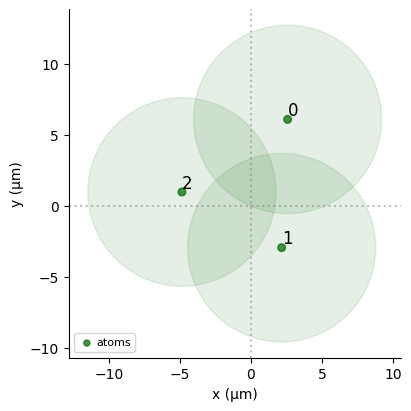

In [9]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

# Quantum Adiabatic Algorithm

In [10]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

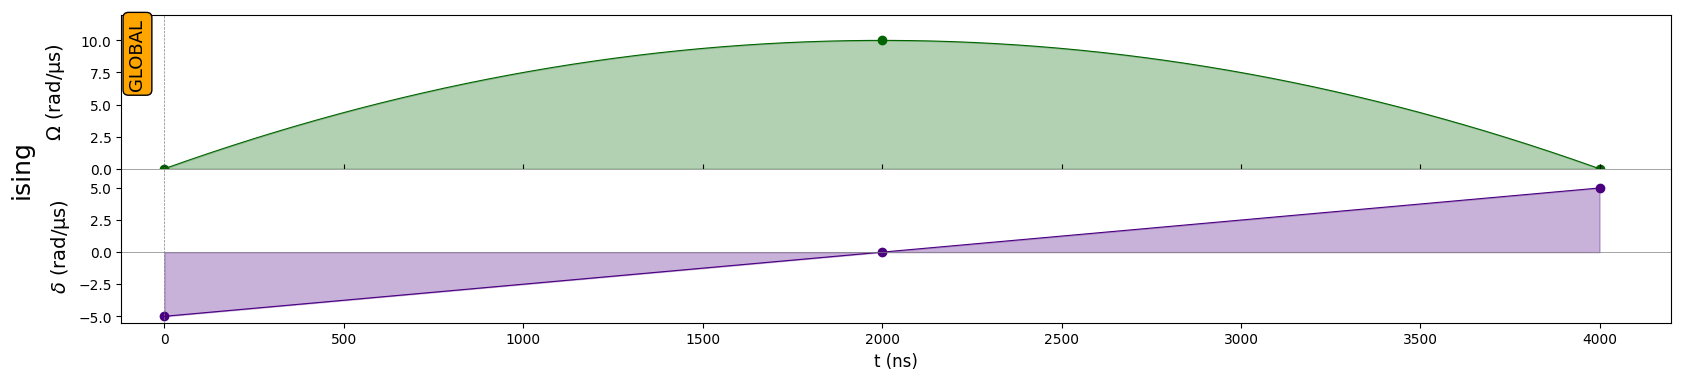

In [11]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [12]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()
print(count_dict)

Counter({'100': 286, '001': 271, '010': 225, '000': 167, '101': 29, '110': 22})


In [13]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

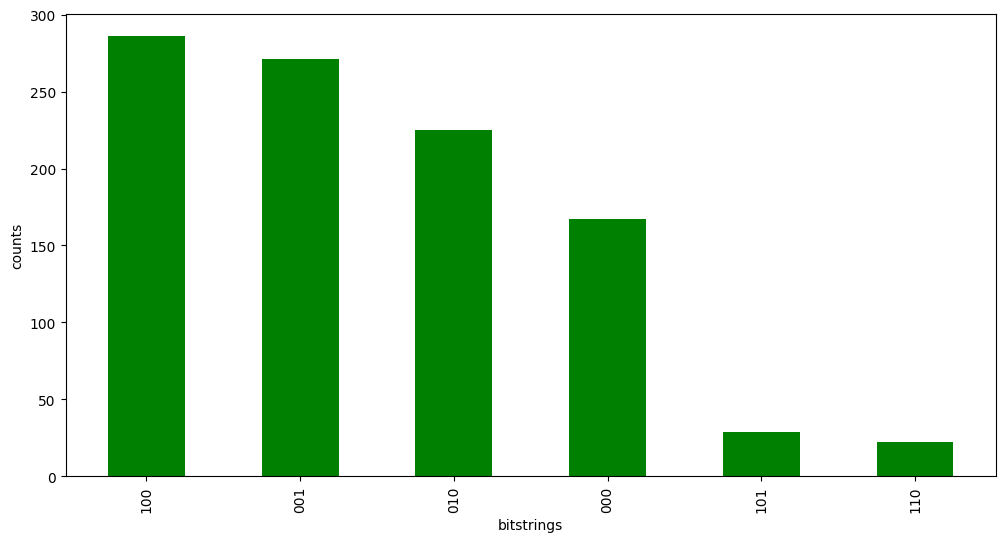

In [14]:
plot_distribution(count_dict)

# How does the time evolution affect the quality of the results?

In [15]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [16]:
cost = []
for T in 1000 * np.linspace(1, 10, 10):
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, Q) / 3)

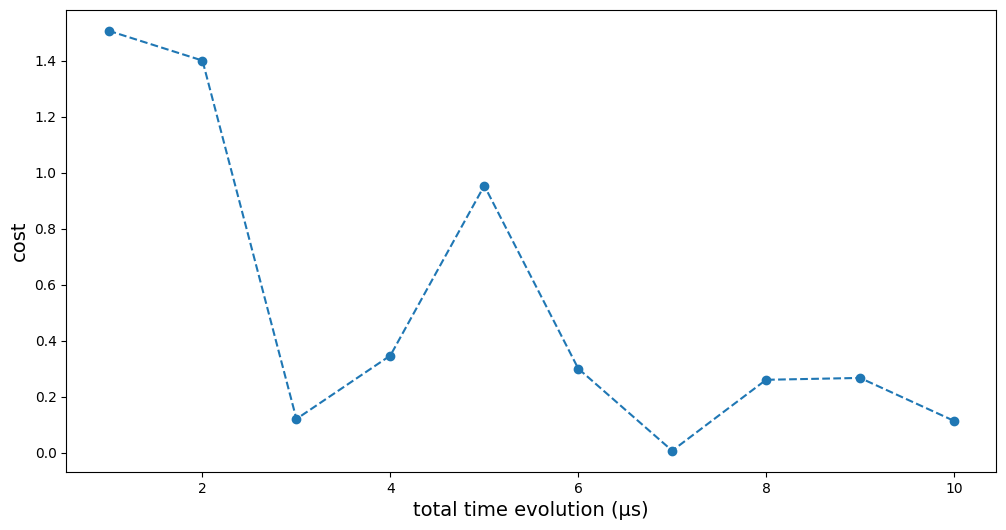

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(cost), "--o")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.show()

In [18]:
def top_n_bitstrings(count_dict, n):
    # Find the top n bit strings with the highest counts
    top_strings = [item[0] for item in count_dict.most_common(n)]
    
    # Convert each bit string to a list of integers
    return [[int(bit) for bit in string] for string in top_strings]

In [19]:
print(top_n_bitstrings(count_dict, 3))

[[1, 0, 0], [0, 0, 1], [0, 1, 0]]
